In [1]:
import pandas as pd
import numpy as np
import wrds
from pandas.tseries.offsets import *
import pickle as pkl
import pyarrow.feather as feather
import os
import warnings
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.linear_model import LinearRegression, Lasso
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import spearmanr
import xgboost as xgb
from xgboost import XGBRegressor
from matplotlib.ticker import MaxNLocator
from typing import Dict, List
from sklearn.model_selection import TimeSeriesSplit
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader

warnings.filterwarnings("ignore", category=FutureWarning)

def v(x,y=5):
    print(x.shape)
    print(x.head(y))

def cm(df):
    cols_with_nan = df.columns[df.isna().any()].tolist()
    rows_with_nan = df[df.isna().any(axis=1)]
    print(cols_with_nan,rows_with_nan)

In [3]:
bp = pd.read_excel('D:/股票项目/basic_predictions.xlsx')
dp1 = pd.read_excel('D:/股票项目/dynamic_allmodel1_predictions.xlsx')
# dp2 = pd.read_excel('D:/股票项目/dynamic_allmodel2_predictions.xlsx')
mp = pd.read_excel('D:/股票项目/memory_predictions.xlsx')
ip = pd.read_excel('D:/股票项目/industry_predictions.xlsx')
# adata = pd.read_excel('D:/股票项目/all_data.xlsx')

,Unnamed: 0,permno,date,pred_ret,memory_type,actual_ret,structural_change
0,552,10182,2016-09-30,-0.019016,train,0.141029,True
1,1010,10259,2016-09-30,-0.088845,train,0.037284,True
2,1684,10514,2016-09-30,-0.002187,train,-0.070081,True
3,2123,10645,2016-09-30,0.044286,train,0.008105,True
4,2711,10866,2016-09-30,-0.000072,train,-0.022359,True
...,...,...,...,...,...,...,...
179700,179280,93397,2021-11-30,0.040304,train,-0.093614,True
179701,179485,93423,2021-11-30,0.040304,train,-0.110868,True
179702,179537,93426,2021-11-30,0.055065,train,0.007040,True
179703,179595,93429,2021-11-30,0.011904,train,-0.019100,True


In [5]:
bp = bp.rename(columns = {
                        'predicted_ret_Linear Regression':'bp_lr',
                        'predicted_ret_Lasso Regression':'bp_lasso',
                        'predicted_ret_Random Forest':'bp_rf',
                        'predicted_ret_Gradient Boosting':'bp_gb',
                        'predicted_ret_XGB':'bp_xgb',
                        'actual_ret':'ar'})
dp1 = dp1.rename(columns = {'prediction_xgb':'dp_xgb','prediction_rf':'dp_rf'})
ip = ip.rename(columns = {'ret_predict':'ip'})
mp = mp.rename(columns = {'pred_ret':'mp'})
mp = mp[['permno','date','mp']]

In [18]:
rank_imputed = pd.read_csv('D:/股票项目/chars60/chars60_rank_imputed.csv')
rank_imputed[:1000].to_excel('D:/股票项目/chars60/chars60_rank_impute.xlsx')
rank_imputed = rank_imputed[[col for col in rank_imputed.columns if col!='Unnamed: 0']]
rdata = rank_imputed.copy()
def fmm(data, group_col='permno'):
    # 1. 分离分组列与数值列
    if group_col not in rdata.columns:
        raise ValueError(f"分组列'{group_col}'不存在于数据中！")
    
    numeric_cols = rdata.select_dtypes(include=np.number).columns.drop(group_col)  # 提取数值列（排除分组列）
    if not numeric_cols.size:
        raise ValueError("数据中没有可填充的数值列！")
    
    # 2. 按分组列计算数值列的中位数（处理空分组和全NaN分组）
    group_medians = rdata.groupby(group_col)[numeric_cols].transform(
        lambda x: x.median() if x.notna().any() else np.nan  # 若分组全为NaN，暂存为NaN
    )
    
    # 3. 用全局中位数填充分组中位数中的NaN（避免全NaN分组无法填充）
    for col in numeric_cols:
        global_median = rdata[col].median()  # 计算全局中位数
        group_medians[col] = group_medians[col].fillna(global_median)  # 填充NaN分组
    
    # 4. 填充原始数据的缺失值
    data_filled = rdata.copy()
    data_filled[numeric_cols] = data_filled[numeric_cols].fillna(group_medians)
    
    # 5. 检查填充结果（可选但重要）
    missing_count = data_filled[numeric_cols].isna().sum().sum()
    if missing_count > 0:
        print(f"警告：填充后仍有 {missing_count} 个缺失值，可能因全NaN分组无法填充，建议手动处理或删除相关行。")
    else:
        print("缺失值填充成功！")
    return data_filled
rdata = fmm(rdata)
rdata = rdata.dropna()
v(rdata)

## 预处理
def preprocess_data(data):
    # 将日期转换为datetime格式并提取年、月
    data['date'] = pd.to_datetime(data['date'])
    data['year'] = data['date'].dt.year
    data['month'] = data['date'].dt.month
    
    # 移除包含缺失值的行
    data = data.dropna()
    
    # 创建滞后收益率特征
    data = data.sort_values(['permno', 'date'])
    data['lag_ret_1'] = data.groupby('permno')['ret'].shift(1)
    data['lag_ret_3'] = data.groupby('permno')['ret'].shift(3)
    # data['lag_ret_6'] = data.groupby('permno')['ret'].shift(6)
    
    # 移除包含NaN的行（由于滞后操作产生）
    data = data.dropna()
    
    return data

## 行业数据
def engineer_features(data):
    # 计算每个月的股票数量
    monthly_stocks = data.groupby(['year', 'month'])['permno'].count().reset_index()
    monthly_stocks.rename(columns={'permno': 'monthly_stocks'}, inplace=True)
    data = pd.merge(data, monthly_stocks, on=['year', 'month'], how='left')
    
    # 计算行业平均收益率
    industry_ret = data.groupby(['ffi49', 'year', 'month'])['ret'].mean().reset_index()
    industry_ret.rename(columns={'ret': 'industry_ret'}, inplace=True)
    data = pd.merge(data, industry_ret, on=['ffi49', 'year', 'month'], how='left')
    
    # 计算市场平均收益率
    market_ret = data.groupby(['year', 'month'])['ret'].mean().reset_index()
    market_ret.rename(columns={'ret': 'market_ret'}, inplace=True)
    data = pd.merge(data, market_ret, on=['year', 'month'], how='left')
    
    return data

processed_data = preprocess_data(rdata)
edata = engineer_features(processed_data)

缺失值填充成功！
(332271, 70)
   gvkey  permno   sic       ret  exchcd  shrcd        date  ffi49  \
0   1004   54594  5080  0.029534     1.0   11.0  2016-10-31     42   
1   1004   54594  5080  0.146721     1.0   11.0  2016-11-30     42   
2   1004   54594  5080 -0.104093     1.0   11.0  2016-12-31     42   
3   1004   54594  5080 -0.029803     1.0   11.0  2017-01-31     42   
4   1004   54594  5080  0.075961     1.0   11.0  2017-02-28     42   

       lag_me  rank_mom36m  ...  rank_lev  rank_me_ia  rank_cfp  rank_hire  \
0  1070329.68     0.014351  ...  0.167702    0.621118  0.540373        1.0   
1  1099377.58     0.000000  ...  0.099602    0.657371  0.541833        0.0   
2  1260678.86     0.000000  ...  0.072897    0.648598  0.461682        0.0   
3  1134573.45     0.014351  ...  0.143363    0.610619  0.582301       -1.0   
4  1098184.71     0.000000  ...  0.123139    0.610284  0.610284        0.0   

   rank_cashdebt   rank_me  rank_ni  rank_roa  rank_grltnoa     log_me  
0            0.

In [6]:
print(edata.columns)

Index(['gvkey', 'permno', 'sic', 'ret', 'exchcd', 'shrcd', 'date', 'ffi49',
       'lag_me', 'rank_mom36m', 'rank_rvar_mean', 'rank_abr', 'rank_op',
       'rank_rd_sale', 'rank_noa', 'rank_bm', 'rank_std_dolvol', 'rank_bm_ia',
       'rank_seas1a', 'rank_nincr', 'rank_dolvol', 'rank_acc', 'rank_adm',
       'rank_mom12m', 'rank_ato', 'rank_pm', 'rank_rsup', 'rank_chtx',
       'rank_rvar_ff3', 'rank_baspread', 'rank_std_turn', 'rank_agr',
       'rank_pctacc', 'rank_beta', 'rank_rdm', 'rank_roe', 'rank_ill',
       'rank_sue', 'rank_sgr', 'rank_chpm', 'rank_lgr', 'rank_alm',
       'rank_herf', 'rank_depr', 'rank_mom1m', 'rank_ep', 'rank_pscore',
       'rank_cash', 'rank_mom60m', 'rank_rna', 'rank_rvar_capm', 'rank_gma',
       'rank_chcsho', 'rank_mom6m', 'rank_zerotrade', 'rank_turn', 'rank_sp',
       'rank_cinvest', 'rank_dy', 'rank_maxret', 'rank_lev', 'rank_me_ia',
       'rank_cfp', 'rank_hire', 'rank_cashdebt', 'rank_me', 'rank_ni',
       'rank_roa', 'rank_grltnoa', 'log_me'

In [6]:
data = pd.merge(bp, ip,on = ['permno','date'], how = 'inner')
data = pd.merge(data, dp1,on = ['permno', 'date'], how = 'inner')
data = pd.merge(data, mp,on = ['permno', 'date'], how = 'inner')
data

,date,permno,ar,bp_lr,bp_lasso,bp_rf,bp_gb,bp_xgb,ip,dp_xgb,dp_rf,actual,active_factors,mp
0,2017-12-31,10026,0.007743,0.017777,0.018794,0.023164,0.020455,0.019731,0.012318,0.028274,0.022844,0.007743,"rank_rvar_capm, rank_rvar_ff3, rank_rvar_mean,...",-0.002264
1,2018-01-31,10026,-0.088191,0.002215,-0.000317,-0.002163,0.002870,0.002976,0.001964,0.017008,0.019190,-0.088191,"rank_rvar_capm, rank_rvar_ff3, log_me, rank_me...",-0.036602
2,2018-02-28,10026,-0.029688,-0.038447,-0.040295,-0.042373,-0.033666,-0.033282,-0.033648,0.017773,0.020235,-0.029688,"log_me, lag_me, rank_me, rank_rvar_capm, rank_...",0.039139
3,2018-03-31,10026,0.019951,-0.001162,-0.001180,-0.002163,0.002495,0.004389,-0.003988,0.013345,0.014006,0.019951,"log_me, lag_me, rank_me, rank_rvar_capm, rank_...",0.024818
4,2018-04-30,10026,0.006224,-0.015788,-0.011618,-0.005772,-0.008071,-0.006636,-0.005238,0.015888,0.013910,0.006224,"rank_rvar_ff3, log_me, lag_me, rank_me, rank_r...",0.029042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158804,2021-06-30,93436,0.087137,0.048638,0.042195,0.042299,0.050047,0.047108,0.036007,0.099574,0.027759,0.087137,"rank_sp, rank_lev, rank_bm, rank_noa, rank_alm...",-0.018905
158805,2021-07-31,93436,0.011034,-0.055459,-0.043678,-0.044160,-0.051896,-0.052750,-0.035274,0.050929,0.028345,0.011034,"rank_sp, rank_lev, rank_noa, rank_rd_sale, ran...",-0.091738
158806,2021-08-31,93436,0.070605,-0.048445,-0.039181,-0.041119,-0.038407,-0.042533,-0.026580,0.028713,0.018254,0.070605,"rank_sp, rank_lev, rank_op, rank_noa, rank_cfp...",0.316699
158807,2021-09-30,93436,0.054042,-0.034696,-0.026069,-0.027845,-0.024575,-0.027601,-0.019474,0.019488,0.018043,0.054042,"rank_lev, rank_sp, rank_noa, rank_op, rank_cfp...",0.097377


In [20]:
## 处理bp
bp_cols = [col for col in data.columns if col.startswith('bp_')]
def get_similarity_weights(row):
        preds = row[bp_cols].values
        n_models = len(preds)
        similarity_matrix = np.zeros((n_models, n_models))
        # 构建相似度矩阵（预测越接近，相似度越高）
        for i in range(n_models):
            for j in range(n_models):
                similarity_matrix[i, j] = 1 / (1 + np.abs(preds[i] - preds[j]))
        
        # 计算每个模型的总相似度（作为权重）
        weights = np.sum(similarity_matrix, axis=1)
        weights = weights / np.sum(weights)  # 归一化
        
        # 加权平均
        return np.sum(preds * weights)
data['bp'] = data.apply(get_similarity_weights, axis=1)

## 处理dp
dp_cols = [col for col in data.columns if col.startswith('dp_')]
data['dp'] = data[dp_cols].mean(axis=1)

data

,date,permno,ar,bp_lr,bp_lasso,bp_rf,bp_gb,bp_xgb,ip,dp_xgb,dp_rf,actual,active_factors,mp,bp,dp_merged,dp
0,2017-12-31,10026,0.007743,0.017777,0.018794,0.023164,0.020455,0.019731,0.012318,0.028274,0.022844,0.007743,"rank_rvar_capm, rank_rvar_ff3, rank_rvar_mean,...",-0.002264,0.019984,0.025559,0.025559
1,2018-01-31,10026,-0.088191,0.002215,-0.000317,-0.002163,0.002870,0.002976,0.001964,0.017008,0.019190,-0.088191,"rank_rvar_capm, rank_rvar_ff3, log_me, rank_me...",-0.036602,0.001117,0.018099,0.018099
2,2018-02-28,10026,-0.029688,-0.038447,-0.040295,-0.042373,-0.033666,-0.033282,-0.033648,0.017773,0.020235,-0.029688,"log_me, lag_me, rank_me, rank_rvar_capm, rank_...",0.039139,-0.037613,0.019004,0.019004
3,2018-03-31,10026,0.019951,-0.001162,-0.001180,-0.002163,0.002495,0.004389,-0.003988,0.013345,0.014006,0.019951,"log_me, lag_me, rank_me, rank_rvar_capm, rank_...",0.024818,0.000474,0.013676,0.013676
4,2018-04-30,10026,0.006224,-0.015788,-0.011618,-0.005772,-0.008071,-0.006636,-0.005238,0.015888,0.013910,0.006224,"rank_rvar_ff3, log_me, lag_me, rank_me, rank_r...",0.029042,-0.009574,0.014899,0.014899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158804,2021-06-30,93436,0.087137,0.048638,0.042195,0.042299,0.050047,0.047108,0.036007,0.099574,0.027759,0.087137,"rank_sp, rank_lev, rank_bm, rank_noa, rank_alm...",-0.018905,0.046058,0.063667,0.063667
158805,2021-07-31,93436,0.011034,-0.055459,-0.043678,-0.044160,-0.051896,-0.052750,-0.035274,0.050929,0.028345,0.011034,"rank_sp, rank_lev, rank_noa, rank_rd_sale, ran...",-0.091738,-0.049590,0.039637,0.039637
158806,2021-08-31,93436,0.070605,-0.048445,-0.039181,-0.041119,-0.038407,-0.042533,-0.026580,0.028713,0.018254,0.070605,"rank_sp, rank_lev, rank_op, rank_noa, rank_cfp...",0.316699,-0.041933,0.023483,0.023483
158807,2021-09-30,93436,0.054042,-0.034696,-0.026069,-0.027845,-0.024575,-0.027601,-0.019474,0.019488,0.018043,0.054042,"rank_lev, rank_sp, rank_noa, rank_op, rank_cfp...",0.097377,-0.028153,0.018766,0.018766


In [25]:
def prepare_data(df, edata, features):
    """准备用于训练仲裁模型的数据"""
    # 合并预测数据和基础数据
    merged_data = pd.merge(df, edata, on=['date', 'permno'], how='inner')
    return merged_data  # 只返回合并后的DataFrame

In [29]:
def calculate_dynamic_weights(data, window_size=24, min_periods=12):
    """基于历史预测误差的动态权重计算"""
    # 确保按时间排序
    data = data.sort_values('date').copy()
    
    # 初始化权重列
    for model in ['ip', 'dp', 'bp', 'mp']:
        data[f'weight_{model}'] = 1/4  # 初始等权重
    
    # 获取唯一日期并排序
    unique_dates = sorted(data['date'].unique())
    
    for i, current_date in enumerate(unique_dates):
        if i < min_periods:
            continue  # 跳过前几个月，数据不足
            
        # 确定时间窗口 (t-24 到 t-1)
        start_idx = max(0, i - window_size)
        start_date = unique_dates[start_idx]
        end_date = unique_dates[i-1]
        
        # 提取窗口数据
        window_data = data[(data['date'] >= start_date) & (data['date'] <= end_date)]
        
        # 计算每个模型的MSE
        model_errors = {}
        for model in ['ip', 'dp', 'bp', 'mp']:
            errors = (window_data[model] - window_data['ar'])**2
            model_errors[model] = errors.mean()
        
        # 计算基于误差的权重（误差越小权重越大）
        total_inverse_error = sum(1/(err + 1e-6) for err in model_errors.values())
        weights = {model: (1/(model_errors[model] + 1e-6)) / total_inverse_error 
                  for model in model_errors}
        
        # 应用权重到当前月
        mask = data['date'] == current_date
        for model, weight in weights.items():
            data.loc[mask, f'weight_{model}'] = weight
    
    # 计算加权预测
    data['weighted_pred'] = (
        data['weight_ip'] * data['ip'] +
        data['weight_dp'] * data['dp'] +
        data['weight_bp'] * data['bp'] +
        data['weight_mp'] * data['mp']
    )
    
    return data

In [30]:
def evaluate_models(data):
    """评估模型表现"""
    model_names = ['ip', 'dp', 'bp', 'mp', 'weighted_pred']
    results = {}
    
    for model in model_names:
        mse = mean_squared_error(data['ar'], data[model])
        r2 = r2_score(data['ar'], data[model])
        corr = data['ar'].corr(data[model])
        
        results[model] = {
            'MSE': mse,
            'R²': r2,
            'Correlation': corr
        }
    
    # 打印结果
    print("模型性能评估:")
    print("{:<15} {:<10} {:<10} {:<12}".format('Model', 'MSE', 'R²', 'Correlation'))
    for model, metrics in results.items():
        print(f"{model:<15} {metrics['MSE']:.6f} {metrics['R²']:.6f} {metrics['Correlation']:.6f}")
    
    return results

In [31]:
def main(data, edata):
    """主函数，整合仲裁模型流程"""
    # 定义特征列表 - 排除非特征列
    exclude_cols = ['gvkey', 'permno', 'ret', 'date', 'ffi49', 'exchcd', 'shrcd', 
                   'year', 'month', 'monthly_stocks', 'industry_ret', 'market_ret',
                   'actual', 'active_factors', 'dp_merged', 'dp_xgb', 'dp_rf']
    
    features = [col for col in data.columns if col not in exclude_cols]
    
    # 准备数据
    merged_data = prepare_data(data, edata, features)
    
    # 计算动态权重
    weighted_data = calculate_dynamic_weights(merged_data)
    
    # 评估模型
    results = evaluate_models(weighted_data)
    
    return weighted_data, results

if __name__ == "__main__":
    # 调用主函数并传入已准备好的数据
    weighted_data, results = main(data, edata)

模型性能评估:
Model           MSE        R²         Correlation 
ip              0.030666 0.328907 0.593457
dp              0.046920 -0.026792 0.023218
bp              0.037128 0.187492 0.435857
mp              0.045513 0.004008 0.210960
weighted_pred   0.035686 0.219069 0.545797


模型性能评估:
Model           MSE        R²         Correlation 
ip              0.030666 0.328907 0.593457
dp              0.046920 -0.026792 0.023218
bp              0.037128 0.187492 0.435857
mp              0.045513 0.004008 0.210960
weighted_pred   0.035686 0.219069 0.545797


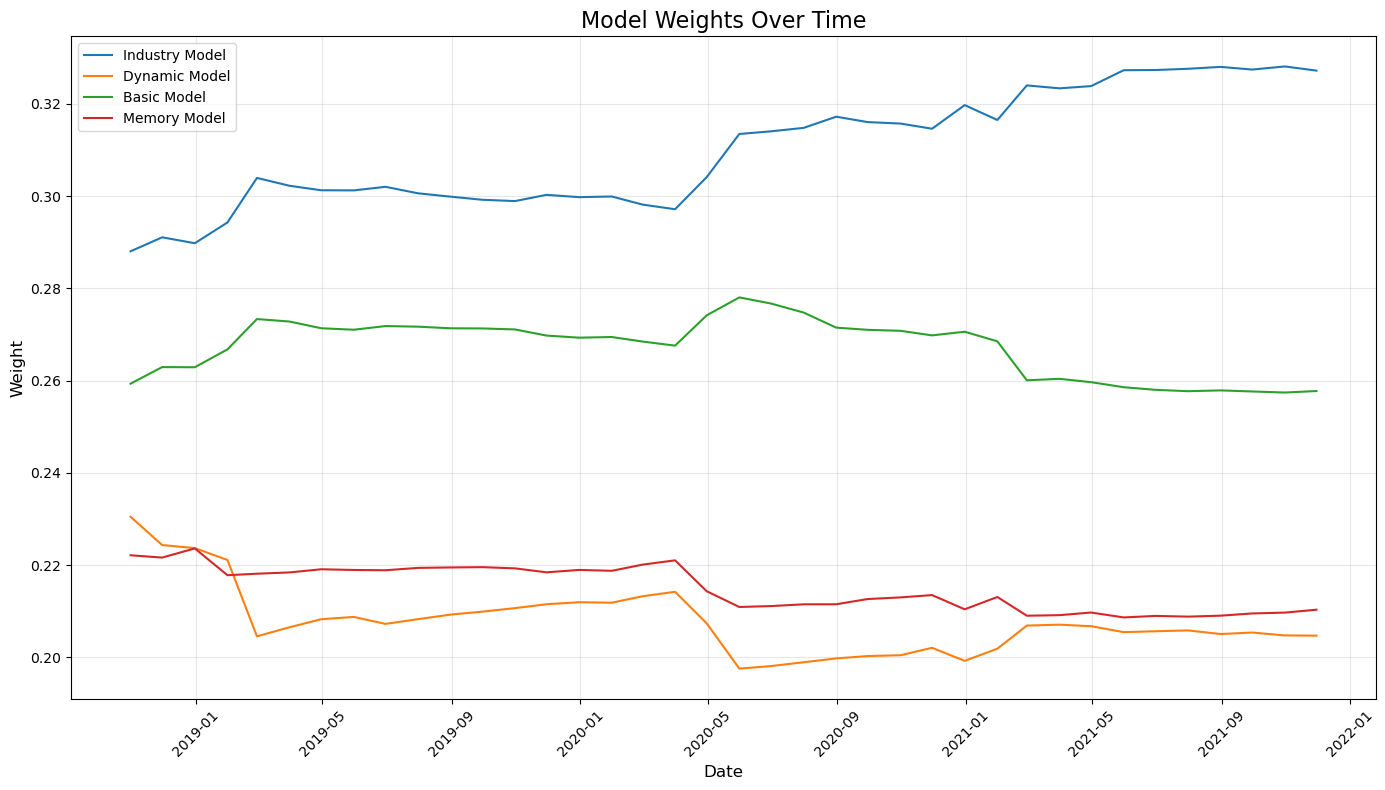

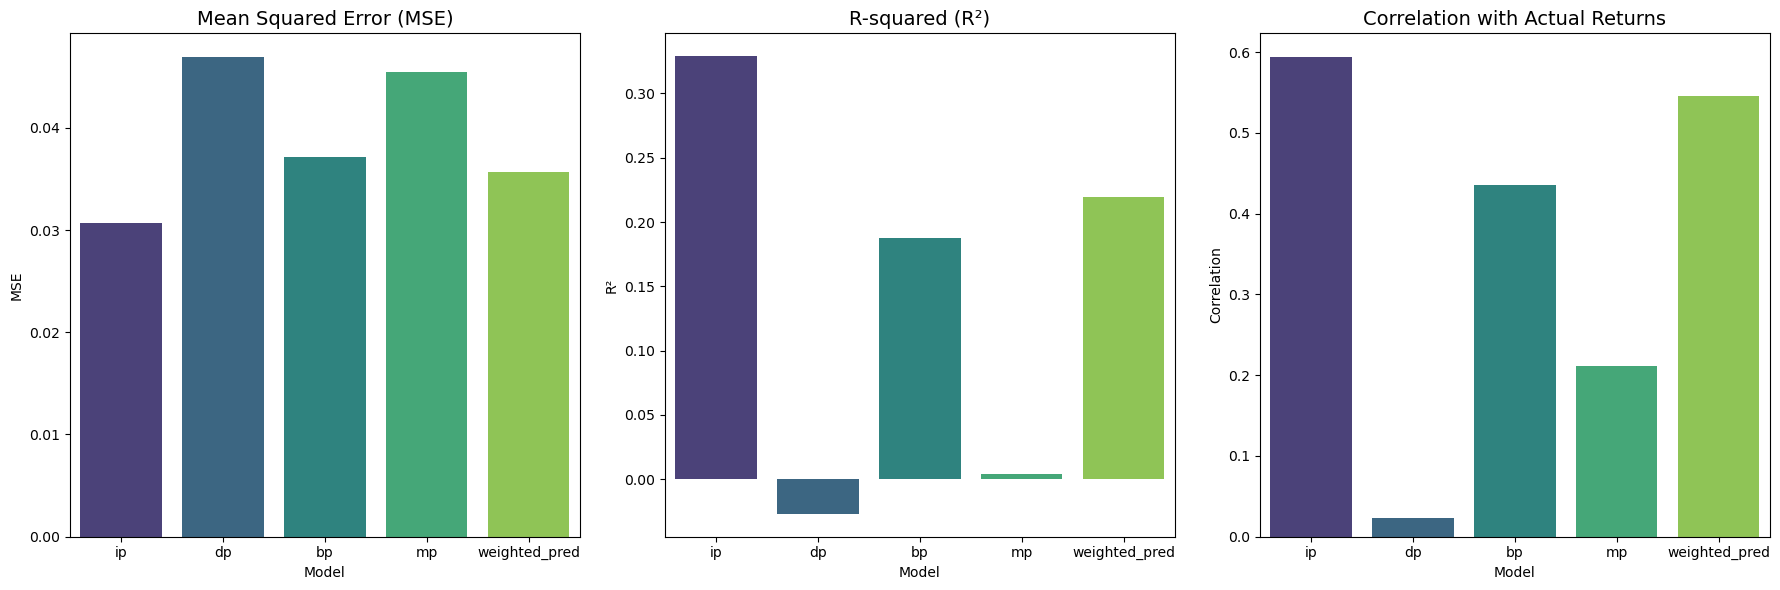

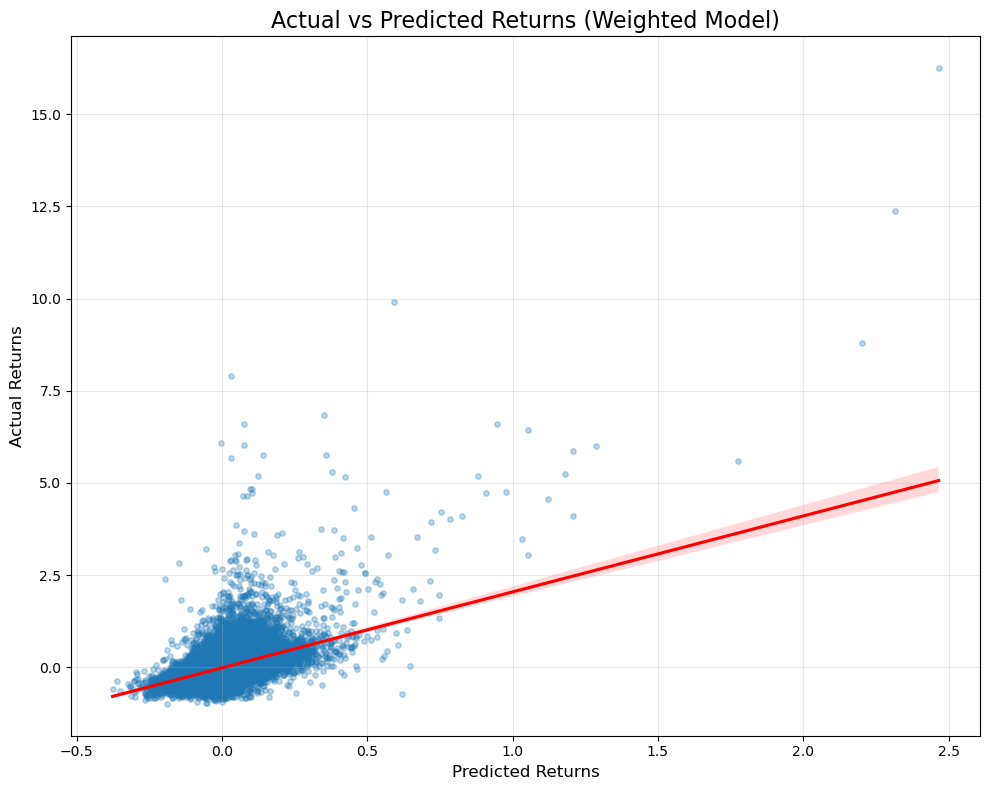

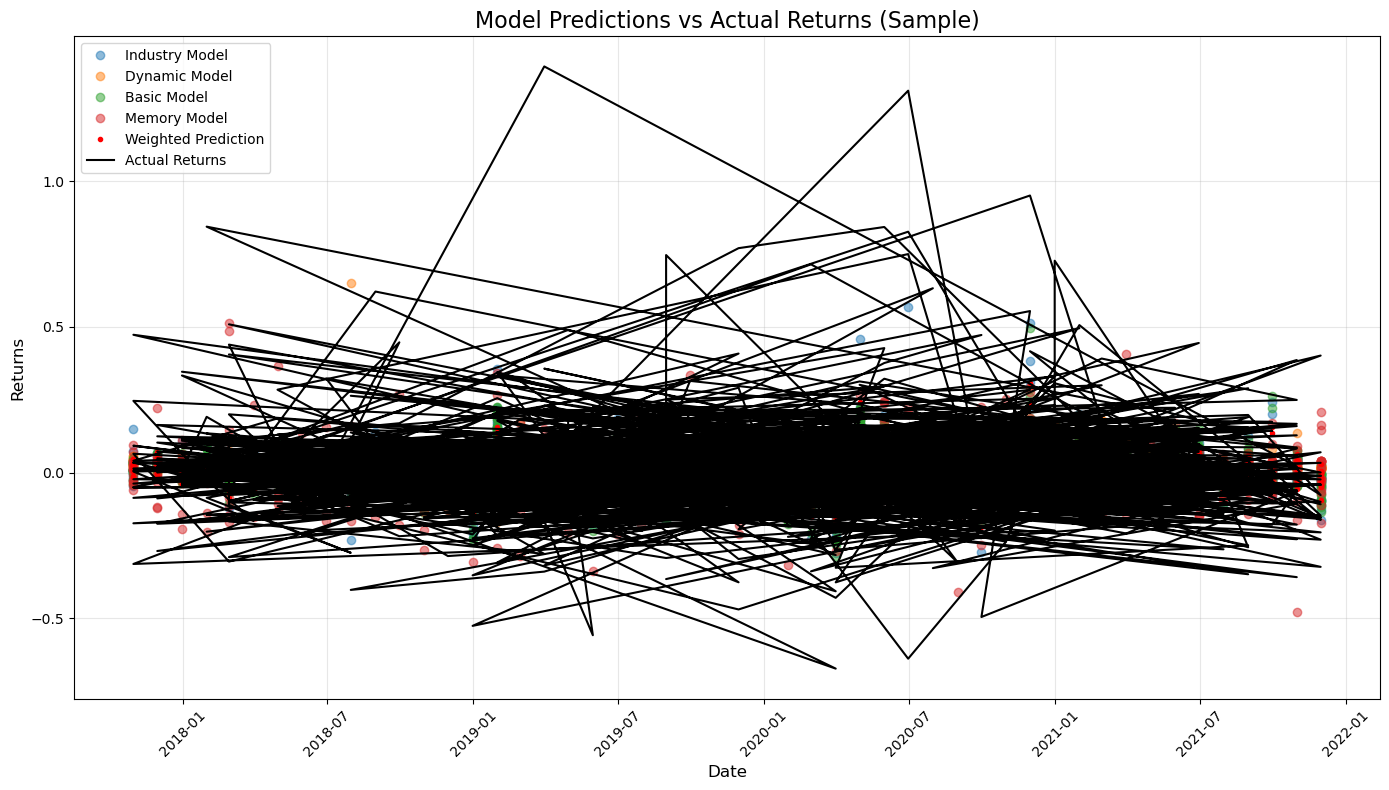

In [32]:
def calculate_dynamic_weights(data, window_size=24, min_periods=12):
    """基于历史预测误差的动态权重计算"""
    # 确保按时间排序
    data = data.sort_values('date').copy()
    
    # 初始化权重列
    for model in ['ip', 'dp', 'bp', 'mp']:
        data[f'weight_{model}'] = 1/4  # 初始等权重
    
    # 获取唯一日期并排序
    unique_dates = sorted(data['date'].unique())
    
    # 存储权重历史用于可视化
    weight_history = []
    
    for i, current_date in enumerate(unique_dates):
        if i < min_periods:
            continue  # 跳过前几个月，数据不足
            
        # 确定时间窗口 (t-24 到 t-1)
        start_idx = max(0, i - window_size)
        start_date = unique_dates[start_idx]
        end_date = unique_dates[i-1]
        
        # 提取窗口数据
        window_data = data[(data['date'] >= start_date) & (data['date'] <= end_date)]
        
        # 计算每个模型的MSE
        model_errors = {}
        for model in ['ip', 'dp', 'bp', 'mp']:
            errors = (window_data[model] - window_data['ar'])**2
            model_errors[model] = errors.mean()
        
        # 计算基于误差的权重（误差越小权重越大）
        total_inverse_error = sum(1/(err + 1e-6) for err in model_errors.values())
        weights = {model: (1/(model_errors[model] + 1e-6)) / total_inverse_error 
                  for model in model_errors}
        
        # 应用权重到当前月
        mask = data['date'] == current_date
        for model, weight in weights.items():
            data.loc[mask, f'weight_{model}'] = weight
        
        # 记录权重历史
        weight_history.append({
            'date': current_date,
            **weights
        })
    
    # 计算加权预测
    data['weighted_pred'] = (
        data['weight_ip'] * data['ip'] +
        data['weight_dp'] * data['dp'] +
        data['weight_bp'] * data['bp'] +
        data['weight_mp'] * data['mp']
    )
    
    # 创建权重历史DataFrame
    weight_df = pd.DataFrame(weight_history)
    
    return data, weight_df

def evaluate_models(data):
    """评估模型表现"""
    model_names = ['ip', 'dp', 'bp', 'mp', 'weighted_pred']
    results = {}
    
    for model in model_names:
        mse = mean_squared_error(data['ar'], data[model])
        r2 = r2_score(data['ar'], data[model])
        corr = data['ar'].corr(data[model])
        
        results[model] = {
            'MSE': mse,
            'R²': r2,
            'Correlation': corr
        }
    
    # 打印结果
    print("模型性能评估:")
    print("{:<15} {:<10} {:<10} {:<12}".format('Model', 'MSE', 'R²', 'Correlation'))
    for model, metrics in results.items():
        print(f"{model:<15} {metrics['MSE']:.6f} {metrics['R²']:.6f} {metrics['Correlation']:.6f}")
    
    return results

def visualize_results(data, weight_df, results):
    """可视化模型权重和性能"""
    
    # 1. 模型权重随时间变化
    plt.figure(figsize=(14, 8))
    plt.plot(weight_df['date'], weight_df['ip'], label='Industry Model')
    plt.plot(weight_df['date'], weight_df['dp'], label='Dynamic Model')
    plt.plot(weight_df['date'], weight_df['bp'], label='Basic Model')
    plt.plot(weight_df['date'], weight_df['mp'], label='Memory Model')
    
    plt.title('Model Weights Over Time', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Weight', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('model_weights_over_time.png', dpi=300)
    plt.show()
    
    # 2. 模型性能对比
    metrics_df = pd.DataFrame(results).T.reset_index()
    metrics_df.rename(columns={'index': 'Model'}, inplace=True)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # MSE对比
    sns.barplot(x='Model', y='MSE', data=metrics_df, ax=axes[0], palette='viridis')
    axes[0].set_title('Mean Squared Error (MSE)', fontsize=14)
    axes[0].set_ylabel('MSE')
    
    # R²对比
    sns.barplot(x='Model', y='R²', data=metrics_df, ax=axes[1], palette='viridis')
    axes[1].set_title('R-squared (R²)', fontsize=14)
    axes[1].set_ylabel('R²')
    
    # Correlation对比
    sns.barplot(x='Model', y='Correlation', data=metrics_df, ax=axes[2], palette='viridis')
    axes[2].set_title('Correlation with Actual Returns', fontsize=14)
    axes[2].set_ylabel('Correlation')
    
    plt.tight_layout()
    plt.savefig('model_performance_comparison.png', dpi=300)
    plt.show()
    
    # 3. 加权预测与实际值散点图
    plt.figure(figsize=(10, 8))
    sns.regplot(x='weighted_pred', y='ar', data=data, 
                scatter_kws={'alpha': 0.3, 's': 15}, 
                line_kws={'color': 'red'})
    
    plt.title('Actual vs Predicted Returns (Weighted Model)', fontsize=16)
    plt.xlabel('Predicted Returns', fontsize=12)
    plt.ylabel('Actual Returns', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('actual_vs_predicted.png', dpi=300)
    plt.show()
    
    # 4. 模型预测对比（抽样）
    sample = data.sample(1000, random_state=42)
    
    plt.figure(figsize=(14, 8))
    plt.plot(sample['date'], sample['ip'], 'o', alpha=0.5, label='Industry Model')
    plt.plot(sample['date'], sample['dp'], 'o', alpha=0.5, label='Dynamic Model')
    plt.plot(sample['date'], sample['bp'], 'o', alpha=0.5, label='Basic Model')
    plt.plot(sample['date'], sample['mp'], 'o', alpha=0.5, label='Memory Model')
    plt.plot(sample['date'], sample['weighted_pred'], 'ro', markersize=3, label='Weighted Prediction')
    plt.plot(sample['date'], sample['ar'], 'k-', linewidth=1.5, label='Actual Returns')
    
    plt.title('Model Predictions vs Actual Returns (Sample)', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Returns', fontsize=12)
    plt.legend(fontsize=10, loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('predictions_vs_actual.png', dpi=300)
    plt.show()

def main(data, edata):
    """主函数，整合仲裁模型流程"""
    # 定义特征列表 - 排除非特征列
    exclude_cols = ['gvkey', 'permno', 'ret', 'date', 'ffi49', 'exchcd', 'shrcd', 
                   'year', 'month', 'monthly_stocks', 'industry_ret', 'market_ret',
                   'actual', 'active_factors', 'dp_merged', 'dp_xgb', 'dp_rf']
    
    features = [col for col in data.columns if col not in exclude_cols]
    
    # 准备数据
    merged_data = prepare_data(data, edata, features)
    
    # 计算动态权重
    weighted_data, weight_df = calculate_dynamic_weights(merged_data)
    
    # 评估模型
    results = evaluate_models(weighted_data)
    
    # 可视化结果
    visualize_results(weighted_data, weight_df, results)
    
    return weighted_data, results, weight_df

if __name__ == "__main__":
    # 调用主函数并传入已准备好的数据
    weighted_data, results, weight_df = main(data, edata)
    
    # 保存结果
    weighted_data.to_csv('D:/股票项目/arbitration_model_results.csv', index=False)
    weight_df.to_csv('D:/股票项目/model_weights_history.csv', index=False)